# Second Neural Network Architecture test

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf


2023-05-04 17:22:44.207873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preprocessing

In [8]:
def load_vehicle_data(vehicles_path='data'):
  csv_path = os.path.join(vehicles_path, "project_data.csv")
  return pd.read_csv(csv_path)

vehicles = load_vehicle_data()
vehicles.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [9]:
vehicles['year'].value_counts()

2017    466
2015    421
2012    415
2013    386
2014    367
2018    366
2016    357
2011    271
2010    234
2019    195
2009    193
2008    145
2007    134
2006    110
2005     85
2020     48
2004     42
2003     23
2002     21
2001     20
1998     12
2000     12
1999     10
1997      3
1996      2
1995      1
1992      1
Name: year, dtype: int64

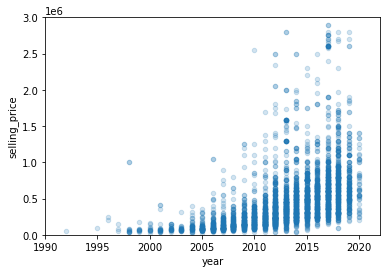

In [4]:
vehicles.plot(kind="scatter", x="year", y="selling_price",
             alpha=0.2)
plt.axis([1990, 2022, 0, 3000000])
plt.show()

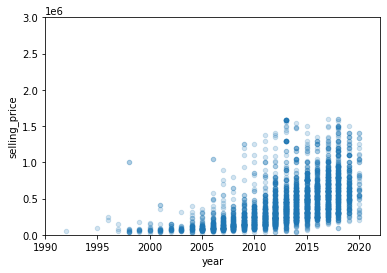

In [10]:
vehicles_copy = vehicles.copy()
# Removing outlier vehicle prices that are dramatically outside standard deviation
vehicles_copy.drop(vehicles_copy[vehicles_copy['selling_price'] >= 1650000].index, inplace = True)

vehicles_copy.plot(kind="scatter", x="year", y="selling_price",
             alpha=0.2)
plt.axis([1990, 2022, 0, 3000000])
plt.show()


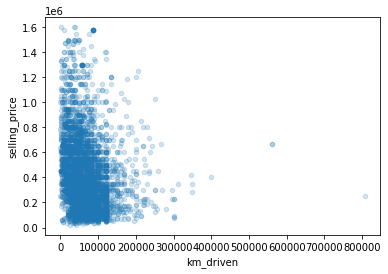

In [17]:
# vehicles_copy = vehicles.copy()
# Removing outlier vehicle prices that are dramatically outside standard deviation
# vehicles_copy.drop(vehicles_copy[vehicles_copy['km_driven'] >= 275000].index, inplace = True)

vehicles_copy.plot(kind="scatter", x="km_driven", y="selling_price",
             alpha=0.2)
# plt.axis([1990, 2022, 0, 3000000])
plt.show()

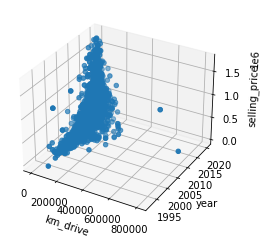

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vehicles['km_driven'], vehicles['year'], vehicles['selling_price'])

ax.set_xlabel('km_drive')
ax.set_ylabel('year')
ax.set_zlabel('selling_price')

plt.show()

In [43]:
vehicles[vehicles['selling_price'] <= 80000]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,0,0,0,1
13,Maruti 800 AC,2007,60000,70000,0,0,0,1
64,Tata Indica DLS,2005,70000,80000,1,0,0,1
82,Hyundai Getz GLS,2005,80000,120000,0,0,0,3
92,Hyundai Santro Xing XO,2007,80000,58000,0,1,0,2
...,...,...,...,...,...,...,...,...
4296,Hyundai Santro Xing XG,2005,70000,68500,0,1,0,1
4301,Maruti Alto LXI,2005,56000,23000,0,0,0,2
4321,Maruti Alto LX,2006,75000,130000,0,0,0,1
4325,Maruti Alto LXi,2000,65000,90000,0,0,0,2


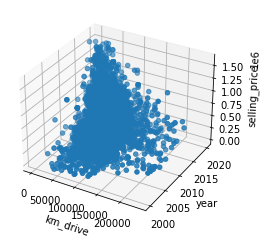

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vehicles_copy['km_driven'], vehicles_copy['year'], vehicles_copy['selling_price'])

ax.set_xlabel('km_drive')
ax.set_ylabel('year')
ax.set_zlabel('selling_price')

plt.show()


In [ ]:
vehicles.drop(vehicles[vehicles['year'] < int("2000")].index, inplace = True)

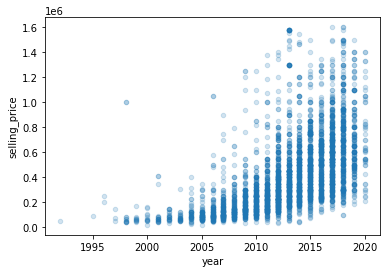

In [27]:
vehicles_copy.plot(kind="scatter", x="year", y="selling_price",
             alpha=0.2)
# plt.axis([0, 250000, 0, 1800000])
plt.show()

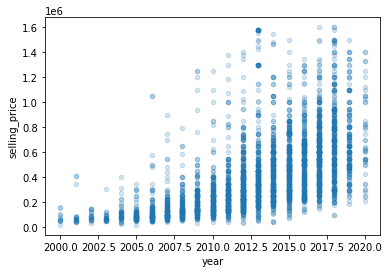

In [32]:
vehicles_copy.drop(vehicles_copy[vehicles_copy['year'] < int("2000")].index, inplace = True)

vehicles_copy.plot(kind="scatter", x="year", y="selling_price",
             alpha=0.2)
# plt.axis([0, 250000, 0, 1800000])
plt.show()

array([[<AxesSubplot:xlabel='year', ylabel='year'>,
        <AxesSubplot:xlabel='selling_price', ylabel='year'>,
        <AxesSubplot:xlabel='km_driven', ylabel='year'>],
       [<AxesSubplot:xlabel='year', ylabel='selling_price'>,
        <AxesSubplot:xlabel='selling_price', ylabel='selling_price'>,
        <AxesSubplot:xlabel='km_driven', ylabel='selling_price'>],
       [<AxesSubplot:xlabel='year', ylabel='km_driven'>,
        <AxesSubplot:xlabel='selling_price', ylabel='km_driven'>,
        <AxesSubplot:xlabel='km_driven', ylabel='km_driven'>]],
      dtype=object)

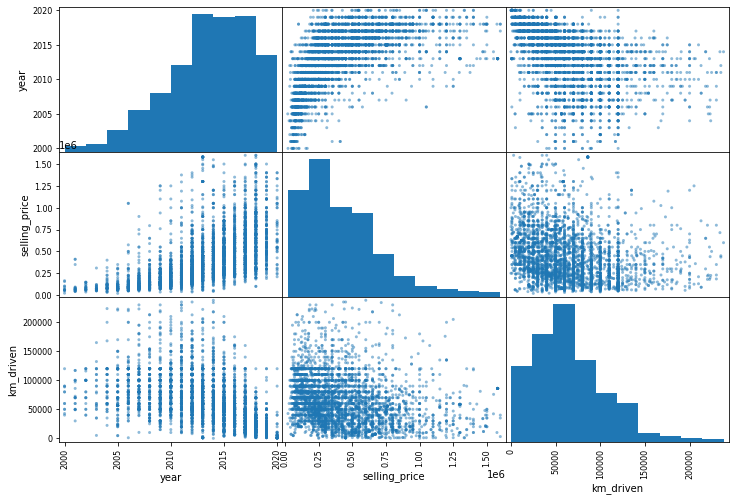

In [44]:
attributes = ["year",	"selling_price", 	"km_driven",	"fuel",	"seller_type",	"transmission",	"owner"]
scatter_matrix(vehicles_copy[attributes], figsize=(12, 8))

In [ ]:
# YEAR TO KM_DRIVE RATIO ???

### Removing noisey data instances

In [11]:
# Removing outlier vehicle prices that are dramatically outside standard deviation
vehicles.drop(vehicles[vehicles['selling_price'] >= 1750000].index, inplace = True)



### Convert categorical data to integers

In [12]:
# CREATING INTEGERS OF NUMBER OF OWNWERS
current_owner_strings = ['First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner']
new_owner_strings = ['1', '2', '3', '4']
vehicles['owner'] = vehicles['owner'].replace(current_owner_strings, new_owner_strings)
vehicles['owner'] = vehicles['owner'].astype('int64') # Convert type to integers:


# 0 index converting for category column's for future one-hot encoded data 

current_owner_strings = ['Petrol', 'Diesel', 'CNG', 'LPG']
new_strings = ['0', '1', '2', '3']
vehicles['fuel'] = vehicles['fuel'].replace(current_owner_strings, new_strings)
vehicles['fuel'] = vehicles['fuel'].astype('int64')


current_owner_strings = ['Individual', 'Dealer', 'Trustmark Dealer']
new_strings = ['0', '1', '2']
vehicles['seller_type'] = vehicles['seller_type'].replace(current_owner_strings, new_strings)
vehicles['seller_type'] = vehicles['seller_type'].astype('int64')


current_owner_strings = ['Manual', 'Automatic']
new_strings = ['0', '1']
vehicles['transmission'] = vehicles['transmission'].replace(current_owner_strings, new_strings)
vehicles['transmission'] = vehicles['transmission'].astype('int64')


In [13]:
vehicles.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,0,0,0,1
1,Maruti Wagon R LXI Minor,2007,135000,50000,0,0,0,1
2,Hyundai Verna 1.6 SX,2012,600000,100000,1,0,0,1
3,Datsun RediGO T Option,2017,250000,46000,0,0,0,1
4,Honda Amaze VX i-DTEC,2014,450000,141000,1,0,0,2


array([[<AxesSubplot:xlabel='year', ylabel='year'>,
        <AxesSubplot:xlabel='selling_price', ylabel='year'>,
        <AxesSubplot:xlabel='km_driven', ylabel='year'>,
        <AxesSubplot:xlabel='fuel', ylabel='year'>,
        <AxesSubplot:xlabel='seller_type', ylabel='year'>,
        <AxesSubplot:xlabel='transmission', ylabel='year'>,
        <AxesSubplot:xlabel='owner', ylabel='year'>],
       [<AxesSubplot:xlabel='year', ylabel='selling_price'>,
        <AxesSubplot:xlabel='selling_price', ylabel='selling_price'>,
        <AxesSubplot:xlabel='km_driven', ylabel='selling_price'>,
        <AxesSubplot:xlabel='fuel', ylabel='selling_price'>,
        <AxesSubplot:xlabel='seller_type', ylabel='selling_price'>,
        <AxesSubplot:xlabel='transmission', ylabel='selling_price'>,
        <AxesSubplot:xlabel='owner', ylabel='selling_price'>],
       [<AxesSubplot:xlabel='year', ylabel='km_driven'>,
        <AxesSubplot:xlabel='selling_price', ylabel='km_driven'>,
        <AxesSubplot:xla

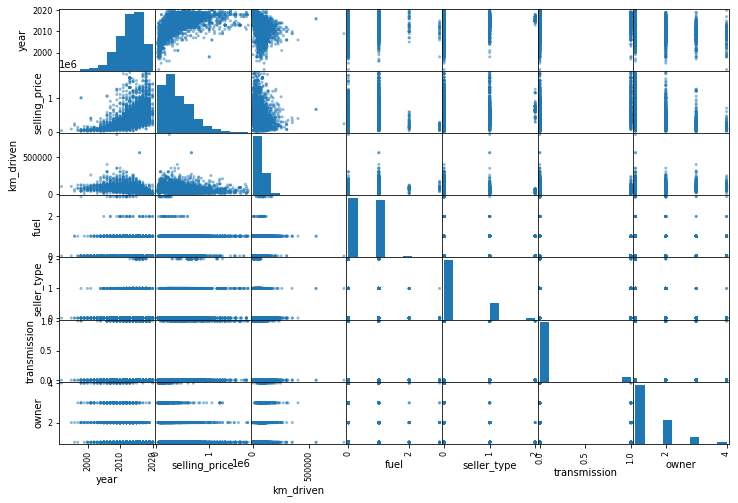

In [14]:
from pandas.plotting import scatter_matrix

attributes = ["year",	"selling_price", 	"km_driven",	"fuel",	"seller_type",	"transmission",	"owner"]
scatter_matrix(vehicles[attributes], figsize=(12, 8))

### Split 20% of data into 'test_set'

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(vehicles, test_size=0.2, random_state=42)

### Create further subsets for multi input model

In [8]:
# Helper function to create a new data set containing 'data_set'
# elements in 'column_name_str' of data set and remove
# that column from 'data_set' input
def extract_data_column_inplace(data_set, column_name_str):
  data_column = data_set[[column_name_str]].copy()
  data_set.drop([column_name_str], axis=1, inplace = True)

  return data_column

Extract categorical data (`fuel`, `seller_type`, `transmission`) to be one hot encoded by model

In [9]:
# Copying and deleting data for one hot coding portion of model
train_set_one_hot_fuel = extract_data_column_inplace(train_set, 'fuel')
train_set_one_hot_seller_type = extract_data_column_inplace(train_set, 'seller_type')
train_set_one_hot_transmission = extract_data_column_inplace(train_set, 'transmission')

test_set_one_hot_fuel = extract_data_column_inplace(test_set, 'fuel')
test_set_one_hot_seller_type = extract_data_column_inplace(test_set, 'seller_type')
test_set_one_hot_transmission = extract_data_column_inplace(test_set, 'transmission')

Removing `name` attribute column from train_set/test_set

In [10]:
train_set_names = extract_data_column_inplace(train_set, 'name')
test_set_names = extract_data_column_inplace(test_set, 'name')

Extracting `selling_price` column as labels

In [11]:
train_set_labels = extract_data_column_inplace(train_set, 'selling_price')
test_set_labels = extract_data_column_inplace(test_set, 'selling_price')

Show new subset results of as they pertain to the train_set

In [12]:
# Could also compare using .head()
print("train_set: \r\n", train_set.columns)
print("train_set_one_hot_fuel: \r\n", train_set_one_hot_fuel.columns) 
print("train_set_one_hot_seller_type: \r\n", train_set_one_hot_seller_type.columns) 
print("train_set_one_hot_transmission: \r\n", train_set_one_hot_transmission.columns) 
print('train_set_names: \r\n', train_set_names.columns)
print('train_set_labels: \r\n', train_set_labels.columns)

train_set: 
 Index(['year', 'km_driven', 'owner'], dtype='object')
train_set_one_hot_fuel: 
 Index(['fuel'], dtype='object')
train_set_one_hot_seller_type: 
 Index(['seller_type'], dtype='object')
train_set_one_hot_transmission: 
 Index(['transmission'], dtype='object')
train_set_names: 
 Index(['name'], dtype='object')
train_set_labels: 
 Index(['selling_price'], dtype='object')


### `Mean Normalization` for numerical attributes to ensure attributes are equally weighted when passed into machine leanring model

In [13]:
train_set.head()

,year,km_driven,owner
2846,2012,62000,2
1249,2016,40000,1
4147,2013,49000,2
1904,2018,1452,1
3683,2015,70000,1


In [14]:
normalized_train_set = (train_set-train_set.mean())/train_set.std()
normalized_test_set = (test_set-test_set.mean())/test_set.std()

In [15]:
normalized_train_set.head()

,year,km_driven,owner
2846,-0.230543,-0.101340,0.746987
1249,0.722007,-0.586263,-0.650749
4147,0.007595,-0.387886,0.746987
1904,1.198282,-1.435936,-0.650749
3683,0.483870,0.074995,-0.650749


## Transforming data into tensors for neural net architecture

In [16]:
train_set_tensor = tf.convert_to_tensor(normalized_train_set)
train_set_one_hot_fuel_tensor = tf.convert_to_tensor(train_set_one_hot_fuel)
train_set_one_hot_seller_type_tensor = tf.convert_to_tensor(train_set_one_hot_seller_type)
train_set_one_hot_transmission_tensor = tf.convert_to_tensor(train_set_one_hot_transmission)
train_set_names_tensor = tf.convert_to_tensor(train_set_names)
train_set_labels_tensor = tf.convert_to_tensor(train_set_labels)


test_set_tensor = tf.convert_to_tensor(normalized_test_set)
test_set_one_hot_fuel_tensor = tf.convert_to_tensor(test_set_one_hot_fuel)
test_set_one_hot_seller_type_tensor = tf.convert_to_tensor(test_set_one_hot_seller_type)
test_set_one_hot_transmission_tensor = tf.convert_to_tensor(test_set_one_hot_transmission)
test_set_names_tensor = tf.convert_to_tensor(test_set_names)
test_set_labels_tensor = tf.convert_to_tensor(test_set_labels)

2023-05-02 20:55:14.181373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create Model Architecture

## Model inputs [numerical values, fuel, seller_type, transmission, name], labels

In [17]:
import numpy as np

In [757]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Globals for word embedding's
EMBEDDING_DIMMENSIONS = 50
VOCARB_SIZE = 1550 # about 1427 unique names identified in dataset
MAX_LENGTH = 40 # approximate the largest vehicle name string


''' Handle data attributes ['year', 'km_driven', 'owner'] '''
numerical_inputs = tf.keras.layers.Input(shape=[3], dtype=tf.float32, name='year_kmDriven_owner_attributes')
# batch_numeric = tf.keras.layers.BatchNormalization()(numerical_inputs)


''' Handle 'name' attribute '''
name_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='name_attribute')

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCARB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LENGTH)
vectorize_layer.adapt(train_set_names) # Create vector table for data
# vectorize_layer.adapt(test_set_names)

vectorized_input = vectorize_layer(name_inputs)
name_embed = tf.keras.layers.Embedding(input_length=MAX_LENGTH, input_dim=VOCARB_SIZE, output_dim=EMBEDDING_DIMMENSIONS, name='embedding')(vectorized_input)
flattened_embedding = tf.keras.layers.Flatten()(name_embed)


''' Handle each one hot encoded input'''
# Handle and encode 'fuel' data
one_hot_input_fuel = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='fuel_attribute')
one_hot_encoder_fuel = tf.keras.layers.CategoryEncoding(num_tokens=4, output_mode='one_hot')(one_hot_input_fuel)

# Handle and encode 'seller_type' data
one_hot_input_seller_type = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='seller_type_attribute')
one_hot_encoder_seller_type = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode='one_hot')(one_hot_input_seller_type)

# Handle and encode 'seller_type' data
one_hot_input_transmission = tf.keras.layers.Input(shape=[1], dtype=tf.int64, name='transmission_attribute')
one_hot_encoder_transmission  = tf.keras.layers.CategoryEncoding(num_tokens=2, output_mode='one_hot')(one_hot_input_transmission)


''' Concatenate all data inputs together '''
all_inputs = tf.keras.layers.Concatenate()([flattened_embedding, numerical_inputs, one_hot_encoder_fuel, one_hot_encoder_seller_type, one_hot_encoder_transmission])


''' MODEL BODY  '''
first_dense = tf.keras.layers.Dense(512, kernel_initializer='he_normal', activation='relu')(all_inputs)
second_dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')(first_dense)
third_dense = tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu')(second_dense)
fourth_dense = tf.keras.layers.Dense(64, kernel_initializer='he_normal', activation='relu')(third_dense)
fifth_dense = tf.keras.layers.Dense(32, kernel_initializer='he_normal', activation='relu')(fourth_dense)
sixth_dense = tf.keras.layers.Dense(8, kernel_initializer='he_normal', activation='relu')(fifth_dense)
seventh_dense = tf.keras.layers.Dense(4, kernel_initializer='he_normal', activation='relu')(sixth_dense)
output = tf.keras.layers.Dense(1, activation='linear')(seventh_dense)
model = tf.keras.Model(inputs=[name_inputs, numerical_inputs , one_hot_input_fuel, one_hot_input_seller_type, one_hot_input_transmission], outputs=[output])
ad_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
model.compile(optimizer=ad_optimizer, loss="mean_squared_error")

In [758]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# history = model.fit([train_set_names_tensor, train_set_tensor, train_set_one_hot_fuel_tensor, train_set_one_hot_seller_type_tensor, train_set_one_hot_transmission_tensor], train_set_labels_tensor, callbacks=[early_stopping_cb], epochs=140, batch_size=32)

# Training with validation split
history = model.fit([train_set_names_tensor , train_set_tensor, train_set_one_hot_fuel_tensor, train_set_one_hot_seller_type_tensor, train_set_one_hot_transmission_tensor], train_set_labels_tensor, validation_split=0.2, callbacks=[early_stopping_cb], epochs=140, batch_size=32)

Epoch 1/140
84/84 [==============================] - 2s 14ms/step - loss: 216899174400.0000 - val_loss: 94430134272.0000
Epoch 2/140
84/84 [==============================] - 1s 10ms/step - loss: 84135952384.0000 - val_loss: 79053438976.0000
Epoch 3/140
84/84 [==============================] - 1s 9ms/step - loss: 61127856128.0000 - val_loss: 44524249088.0000
Epoch 4/140
84/84 [==============================] - 1s 9ms/step - loss: 33951406080.0000 - val_loss: 29255655424.0000
Epoch 5/140
84/84 [==============================] - 1s 9ms/step - loss: 23712860160.0000 - val_loss: 21527224320.0000
Epoch 6/140
84/84 [==============================] - 1s 9ms/step - loss: 18146480128.0000 - val_loss: 19042772992.0000
Epoch 7/140
84/84 [==============================] - 1s 9ms/step - loss: 14613097472.0000 - val_loss: 17031726080.0000
Epoch 8/140
84/84 [==============================] - 1s 9ms/step - loss: 12442081280.0000 - val_loss: 15053520896.0000
Epoch 9/140
84/84 [==========================

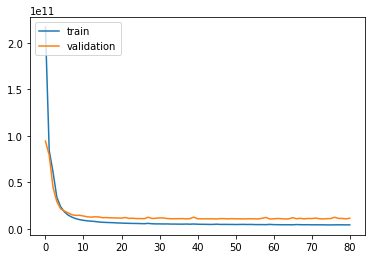

In [759]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

In [760]:
index = 0
percentage_totals = 0
for item in model.predict([test_set_names_tensor, test_set_tensor, test_set_one_hot_fuel_tensor, test_set_one_hot_seller_type_tensor, test_set_one_hot_transmission_tensor]):
  # print(f'(predicted, actual) = ({item[0]},{test_set_labels_tensor[index].numpy()})')
  # print(f"predicted - actual = {item[0] - test_set_labels_tensor[index].numpy()}")

  percentage_error = ((test_set_labels_tensor[index].numpy() - item[0]) / test_set_labels_tensor[index].numpy() ) * 100
  # print("percentage_error = ", percentage_error)

  percentage_totals += abs(percentage_error)
  
  index += 1



print("AVERAGE PERCENTAGE ERROR = ", percentage_totals / len(test_set_labels_tensor))

27/27 [==============================] - 0s 2ms/step
AVERAGE PERCENTAGE ERROR =  [20.39517359]


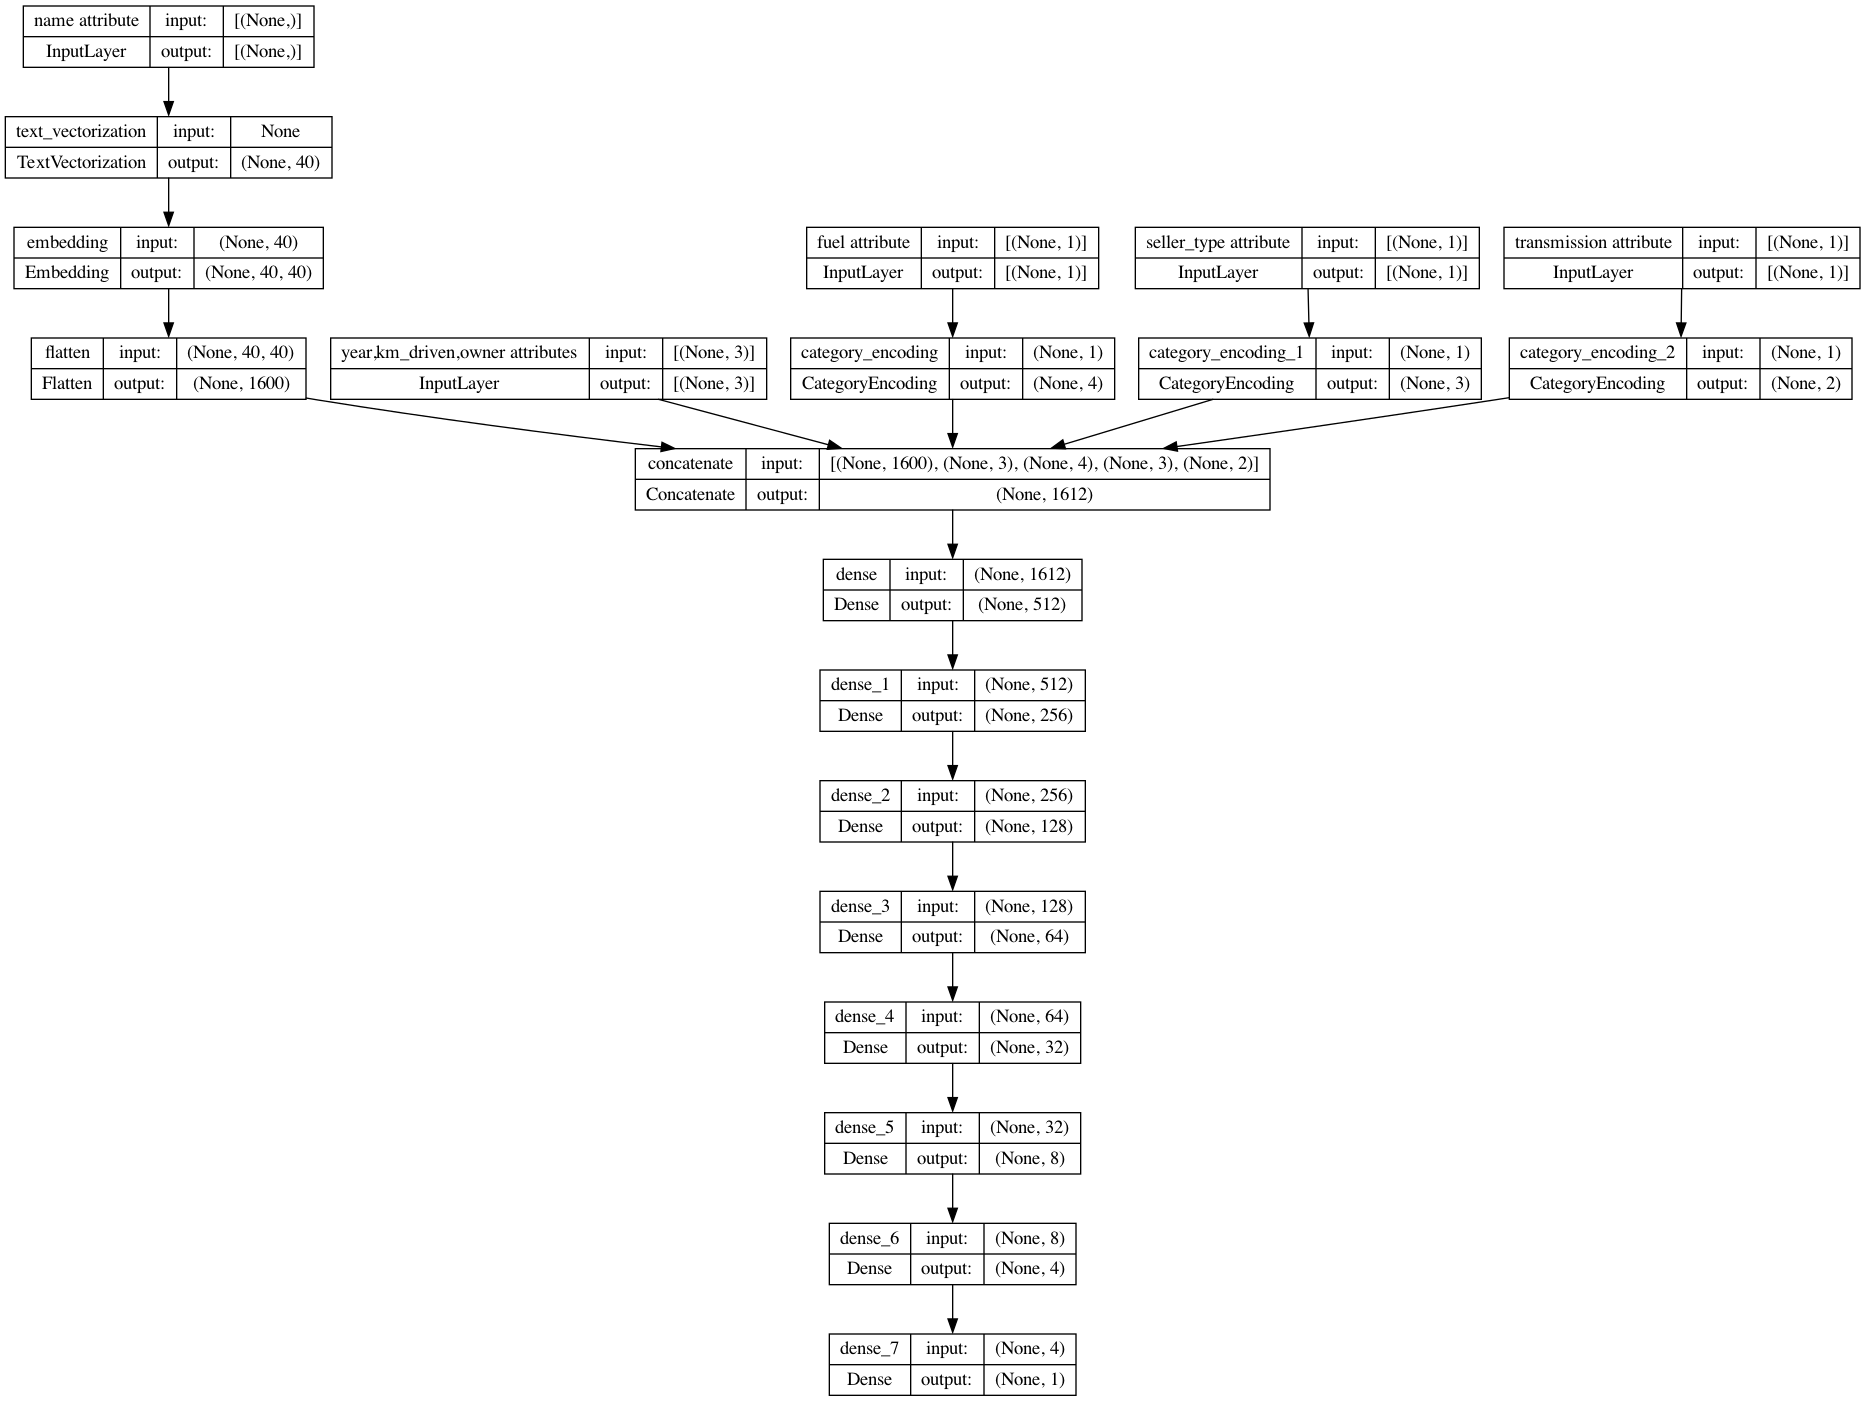

In [697]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Saving Model and Training data

In [762]:
tf.keras.Model.save(model, 'model_20_4_percentage_error')

INFO:tensorflow:Assets written to: model_20_4_percentage_error/assets


INFO:tensorflow:Assets written to: model_20_4_percentage_error/assets


In [765]:
new_mod = tf.keras.models.load_model('model_20_4_percentage_error')
index = 0
percentage_totals = 0
for item in new_mod.predict([test_set_names_tensor, test_set_tensor, test_set_one_hot_fuel_tensor, test_set_one_hot_seller_type_tensor, test_set_one_hot_transmission_tensor]):
  # print(f'(predicted, actual) = ({item[0]},{test_set_labels_tensor[index].numpy()})')
  # print(f"predicted - actual = {item[0] - test_set_labels_tensor[index].numpy()}")

  percentage_error = ((test_set_labels_tensor[index].numpy() - item[0]) / test_set_labels_tensor[index].numpy() ) * 100
  # print("percentage_error = ", percentage_error)

  percentage_totals += abs(percentage_error)
  
  index += 1



print("AVERAGE PERCENTAGE ERROR = ", percentage_totals / len(test_set_labels_tensor))

27/27 [==============================] - 0s 5ms/step
AVERAGE PERCENTAGE ERROR =  [20.39517359]


### Saving Training History

In [764]:
import pickle

with open('model_20_4_percentage_error_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Loading Model and Training data

In [18]:
loaded_model = tf.keras.models.load_model('model_20_4_percentage_error')

### Evaluating Performance on Test Set

In [19]:
loaded_model.evaluate([test_set_names_tensor, test_set_tensor, test_set_one_hot_fuel_tensor, test_set_one_hot_seller_type_tensor, test_set_one_hot_transmission_tensor], test_set_labels_tensor)

27/27 [==============================] - 1s 3ms/step - loss: 13656311808.0000


13656311808.0